# Basic Training Scheme development notebook

## Importing section

In [1]:
import torch
from torch import optim, nn
from torch.utils.data import random_split, DataLoader
from etnn.data.ferris_wheel import load_pure_ferris_wheel_dataset
from etnn.data.tree_structure import TreeNode
from etnn.nn.layer_framework import LayerManagementFramework
from tqdm import tqdm
import matplotlib.pyplot as plt
from etnn.tools.training import train_epoch, eval_epoch
from etnn.tools.training_tools import EpochControl, ConfigStore, AccuracyManager, seeding_all

In [2]:
import numpy as np
import pandas as pd
import os

## Parameter definition

In [3]:
NUM_GONDOLAS = 10
NUM_PART_PG = 5
DATASET_SIZE = 10_000
DATASET_PATH = "../datasets"

In [4]:
val_perc = 0.1
test_perc = 0.2

In [5]:
SAVING_PATH = "."
MODEL_SAVING_NAME = "model.pt"

In [6]:
CONFIG_SAVING_NAME = "config.json"
ACCURACY_SAVING_NAME = "accuracies.csv"
RESULTS_FOLDER = "."

In [7]:
# todo: take care of None values as representing not yet implemented features
config = ConfigStore(
    in_dim=15,
    hidden_dim=128,
    out_dim=1,
    k=2,
    is_accuracy_score=False,
    which_score=None,
    loss_name=None,
    optimizer_name=None,
    num_max_epochs=100, # old: 20
    learning_rate=0.001,
    batch_size=1024,
    early_stop_tol=5,
    is_classification=False
)

## data preparation

In [8]:
dataset = load_pure_ferris_wheel_dataset(
    num_gondolas=NUM_GONDOLAS,
    num_part_pg=NUM_PART_PG,
    num_to_generate=DATASET_SIZE,
    dataset_path=DATASET_PATH
)

In [9]:
len(dataset)

10000

In [10]:
generator = torch.Generator().manual_seed(420)
train_ds, val_ds, test_ds = random_split(
    dataset,
    [1-val_perc-test_perc, val_perc, test_perc],
    generator=generator
)

In [11]:
train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=config.batch_size, shuffle=False)

In [12]:
# todo: add more tree mutated sequences that are in dataset
# todo: add some faulty sequences which disturb this and see how much this affects the training

## Build tree structure

In [13]:
tree_structure = TreeNode(
    node_type="C",
    children=[
        TreeNode("P", [TreeNode("E", NUM_PART_PG)])
        for _ in range(NUM_GONDOLAS)
    ]
)

## Define device

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
# device = 'cpu'

In [16]:
device

'cuda'

## Set seeds for reproducibility

In [17]:
seeding_all(420)

## Define Model

In [18]:
model = LayerManagementFramework(
    in_dim=config.in_dim,
    tree=tree_structure,
    hidden_dim=config.hidden_dim,
    out_dim=config.out_dim,
    k=config.k
).to(device)

In [19]:
from etnn.nn.baseline import create_baseline_model, calc_params
model, _ =  create_baseline_model(
    n_params=calc_params(model),
    input_dim=config.in_dim * NUM_GONDOLAS * NUM_PART_PG,
    n_layer=3,
    output_dim=1
)
model = model.to(device)

In [20]:
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=750, out_features=129, bias=True)
  (2): ReLU()
  (3): Linear(in_features=129, out_features=11, bias=True)
  (4): ReLU()
  (5): Linear(in_features=11, out_features=1, bias=True)
)

## Define Loss and Optimizers

In [21]:
criterion = nn.MSELoss()

In [22]:
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)

## Training

In [23]:
# init loss history
loss_history_train = []
loss_history_test = []

In [24]:
epoch_control = EpochControl(
    model_save_name=MODEL_SAVING_NAME,
    config_save_name=CONFIG_SAVING_NAME,
    saving_folder_path=SAVING_PATH,
    tolerance=config.early_stop_tol,
    is_accuracy_score=config.is_accuracy_score
)

In [25]:
accuracy_protocoller = AccuracyManager(
    storage_name=ACCURACY_SAVING_NAME,
    storage_path=RESULTS_FOLDER,
    is_classification=False
)

In [26]:
# train for N epochs
for epoch in tqdm(range(config.num_max_epochs)):
    train_mean_loss, train_true_y, train_pred_y = train_epoch(
        model,
        train_loader,
        optimizer,
        device,
        criterion
    )

    loss_history_train += [train_mean_loss]

    val_mean_loss, val_true_y, val_pred_y = eval_epoch(
        model,
        test_loader,
        device,
        criterion
    )
    loss_history_test += [val_mean_loss]

    # use accuracy manager to calc accuracy metrics and save them
    accuracy_protocoller.calc_and_collect(
        config_id="t1",
        epoch=epoch+1,
        train_y_true=train_true_y,
        train_y_pred=train_pred_y,
        train_loss=train_mean_loss,
        val_y_true=val_true_y,
        val_y_pred=val_pred_y,
        val_loss=val_mean_loss,
    )

    # check if model is better and save it
    if epoch_control.retain_best_and_stop(model, train_mean_loss, val_mean_loss, config):
        break

  1%|          | 1/100 [00:03<06:35,  3.99s/it]

++save++


  2%|▏         | 2/100 [00:07<05:44,  3.52s/it]

++save++


  3%|▎         | 3/100 [00:10<05:21,  3.31s/it]

++save++


  4%|▍         | 4/100 [00:13<05:15,  3.29s/it]

++save++


  5%|▌         | 5/100 [00:16<05:07,  3.24s/it]

++save++


  6%|▌         | 6/100 [00:19<04:59,  3.19s/it]

++save++


  7%|▋         | 7/100 [00:22<04:54,  3.16s/it]

++save++


  8%|▊         | 8/100 [00:26<04:53,  3.19s/it]

++save++


  9%|▉         | 9/100 [00:29<04:47,  3.16s/it]

++save++


 10%|█         | 10/100 [00:32<04:43,  3.14s/it]

++save++


 11%|█         | 11/100 [00:35<04:38,  3.13s/it]

++save++


 12%|█▏        | 12/100 [00:38<04:37,  3.16s/it]

++save++


 13%|█▎        | 13/100 [00:41<04:33,  3.14s/it]

++save++


 14%|█▍        | 14/100 [00:44<04:31,  3.15s/it]

++save++


 15%|█▌        | 15/100 [00:48<04:30,  3.18s/it]

++save++


 16%|█▌        | 16/100 [00:51<04:26,  3.17s/it]

++save++


 17%|█▋        | 17/100 [00:54<04:24,  3.19s/it]

++save++


 18%|█▊        | 18/100 [00:57<04:18,  3.16s/it]

++save++


 19%|█▉        | 19/100 [01:00<04:15,  3.15s/it]

++save++


 20%|██        | 20/100 [01:03<04:11,  3.15s/it]

++save++


 21%|██        | 21/100 [01:07<04:09,  3.16s/it]

++save++


 22%|██▏       | 22/100 [01:10<04:07,  3.17s/it]

++save++


 23%|██▎       | 23/100 [01:13<04:11,  3.27s/it]

++save++


 24%|██▍       | 24/100 [01:17<04:28,  3.53s/it]

++save++


 25%|██▌       | 25/100 [01:21<04:29,  3.59s/it]

++save++


 26%|██▌       | 26/100 [01:25<04:33,  3.70s/it]

++save++


 27%|██▋       | 27/100 [01:29<04:40,  3.84s/it]

++save++


 28%|██▊       | 28/100 [01:33<04:40,  3.90s/it]

++save++


 29%|██▉       | 29/100 [01:37<04:36,  3.90s/it]

++save++


 30%|███       | 30/100 [01:41<04:36,  3.95s/it]

++save++


 31%|███       | 31/100 [01:45<04:35,  3.99s/it]

++save++


 32%|███▏      | 32/100 [01:49<04:32,  4.01s/it]

++save++


 33%|███▎      | 33/100 [01:54<04:31,  4.05s/it]

++save++


 34%|███▍      | 34/100 [01:58<04:25,  4.02s/it]

++save++


 35%|███▌      | 35/100 [02:01<04:18,  3.98s/it]

++save++


 36%|███▌      | 36/100 [02:05<04:14,  3.97s/it]

++save++


 37%|███▋      | 37/100 [02:09<04:09,  3.96s/it]

++save++


 38%|███▊      | 38/100 [02:13<04:05,  3.96s/it]

++save++


 39%|███▉      | 39/100 [02:17<04:01,  3.97s/it]

++save++


 40%|████      | 40/100 [02:21<03:58,  3.97s/it]

++save++


 41%|████      | 41/100 [02:25<03:59,  4.06s/it]

++save++


 42%|████▏     | 42/100 [02:29<03:52,  4.00s/it]

++save++


 43%|████▎     | 43/100 [02:33<03:47,  4.00s/it]

++save++


 44%|████▍     | 44/100 [02:37<03:42,  3.97s/it]

++save++


 45%|████▌     | 45/100 [02:41<03:39,  4.00s/it]

++save++


 46%|████▌     | 46/100 [02:45<03:37,  4.03s/it]

++save++


 47%|████▋     | 47/100 [02:50<03:38,  4.12s/it]

++save++


 48%|████▊     | 48/100 [02:54<03:33,  4.10s/it]

++save++


 49%|████▉     | 49/100 [02:58<03:29,  4.10s/it]

++save++


 50%|█████     | 50/100 [03:02<03:22,  4.05s/it]

++save++


 51%|█████     | 51/100 [03:06<03:21,  4.12s/it]

++save++


 52%|█████▏    | 52/100 [03:10<03:16,  4.10s/it]

++save++


 53%|█████▎    | 53/100 [03:14<03:12,  4.10s/it]

++save++


 55%|█████▌    | 55/100 [03:22<03:00,  4.00s/it]

++save++


 56%|█████▌    | 56/100 [03:26<02:55,  3.99s/it]

++save++


 57%|█████▋    | 57/100 [03:30<02:49,  3.94s/it]

++save++


 58%|█████▊    | 58/100 [03:34<02:46,  3.96s/it]

++save++


 59%|█████▉    | 59/100 [03:38<02:45,  4.04s/it]

++save++


 60%|██████    | 60/100 [03:43<02:48,  4.20s/it]

++save++


 61%|██████    | 61/100 [03:46<02:31,  3.88s/it]

++save++


 62%|██████▏   | 62/100 [03:49<02:18,  3.65s/it]

++save++


 63%|██████▎   | 63/100 [03:52<02:12,  3.57s/it]

++save++


 65%|██████▌   | 65/100 [03:59<01:58,  3.38s/it]

++save++


 67%|██████▋   | 67/100 [04:05<01:47,  3.24s/it]

++save++


 69%|██████▉   | 69/100 [04:11<01:38,  3.16s/it]

++save++


 71%|███████   | 71/100 [04:18<01:33,  3.23s/it]

++save++


 72%|███████▏  | 72/100 [04:21<01:29,  3.18s/it]

++save++


 73%|███████▎  | 73/100 [04:24<01:25,  3.15s/it]

++save++


 74%|███████▍  | 74/100 [04:27<01:22,  3.17s/it]

++save++


 75%|███████▌  | 75/100 [04:30<01:18,  3.14s/it]

++save++


 76%|███████▌  | 76/100 [04:33<01:14,  3.12s/it]

++save++


 77%|███████▋  | 77/100 [04:36<01:12,  3.15s/it]

++save++


 78%|███████▊  | 78/100 [04:39<01:08,  3.13s/it]

++save++


 79%|███████▉  | 79/100 [04:43<01:06,  3.15s/it]

++save++


 81%|████████  | 81/100 [04:49<00:59,  3.13s/it]

++save++


 82%|████████▏ | 82/100 [04:52<00:56,  3.13s/it]

++save++


 84%|████████▍ | 84/100 [04:58<00:50,  3.15s/it]

++save++


 85%|████████▌ | 85/100 [05:01<00:46,  3.11s/it]

++save++


 86%|████████▌ | 86/100 [05:05<00:43,  3.10s/it]

++save++


 87%|████████▋ | 87/100 [05:08<00:40,  3.10s/it]

++save++


 88%|████████▊ | 88/100 [05:11<00:37,  3.11s/it]

++save++


 90%|█████████ | 90/100 [05:17<00:30,  3.07s/it]

++save++


 92%|█████████▏| 92/100 [05:23<00:24,  3.09s/it]

++save++


 93%|█████████▎| 93/100 [05:26<00:21,  3.07s/it]

++save++


 94%|█████████▍| 94/100 [05:29<00:18,  3.09s/it]

++save++


 95%|█████████▌| 95/100 [05:32<00:15,  3.09s/it]

++save++


 96%|█████████▌| 96/100 [05:35<00:12,  3.09s/it]

++save++


 98%|█████████▊| 98/100 [05:42<00:06,  3.15s/it]

++save++


 99%|█████████▉| 99/100 [05:45<00:03,  3.14s/it]

++save++


100%|██████████| 100/100 [05:48<00:00,  3.49s/it]

++save++


In [27]:
df_measures = pd.read_csv(os.path.join(SAVING_PATH, ACCURACY_SAVING_NAME))
df_measures

,config_id,epoch,train_loss,val_loss,test_loss,train_mse,train_msa,train_explained_variance,train_r2,val_mse,val_msa,val_explained_variance,val_r2,test_mse,test_msa,test_explained_variance,test_r2
0,t1,1,24606.152344,539.302979,0.0,25083.748047,133.097809,-826.972900,-827.047995,539.447937,19.025318,-11.252192,-17.083099,0.0,0.0,0.0,0.0
1,t1,2,698.934692,408.509277,0.0,708.796265,21.473835,-17.423851,-22.398308,408.535004,17.104309,-5.637973,-12.694703,0.0,0.0,0.0,0.0
2,t1,3,298.353943,249.637451,0.0,301.655792,14.144170,-6.046451,-8.958058,249.744705,12.793627,-3.426714,-7.371815,0.0,0.0,0.0,0.0
3,t1,4,212.611618,173.380890,0.0,214.741791,11.815853,-4.104080,-6.088912,173.410004,10.780994,-3.028047,-4.812961,0.0,0.0,0.0,0.0
4,t1,5,158.733047,140.633499,0.0,159.770630,10.172484,-3.239800,-4.274241,140.701126,9.406261,-2.916242,-3.716512,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,t1,96,36.898937,36.296650,0.0,36.862858,4.851850,-0.216717,-0.216892,36.278595,4.800641,-0.216113,-0.216113,0.0,0.0,0.0,0.0
96,t1,97,36.842560,36.463940,0.0,36.863430,4.852545,-0.216829,-0.216911,36.444969,4.795218,-0.211772,-0.221690,0.0,0.0,0.0,0.0
97,t1,98,36.708248,36.290710,0.0,36.816456,4.847815,-0.215247,-0.215360,36.271828,4.788035,-0.210819,-0.215886,0.0,0.0,0.0,0.0
98,t1,99,36.715977,36.212387,0.0,36.769081,4.843681,-0.213424,-0.213796,36.193420,4.784157,-0.209426,-0.213258,0.0,0.0,0.0,0.0


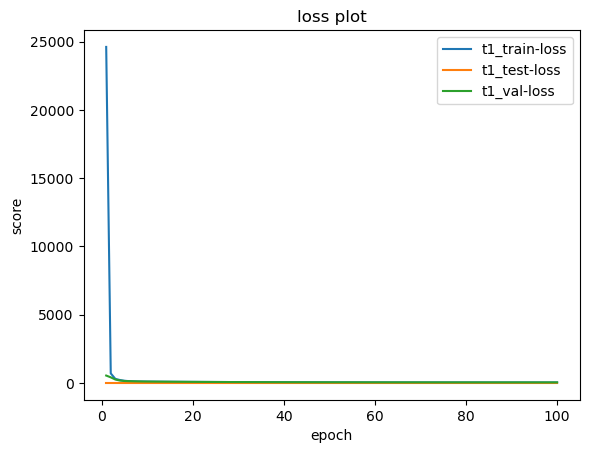

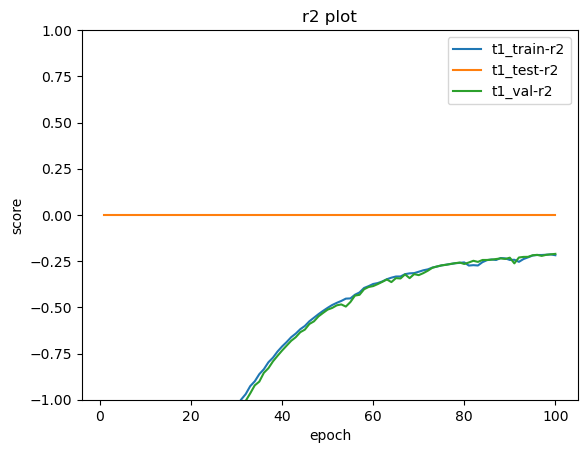

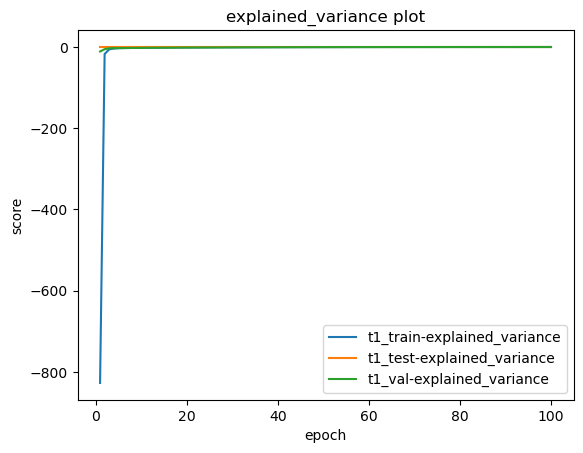

In [28]:
for what in ['loss', 'r2', 'explained_variance']:
    plt.figure()
    for config_id in df_measures.config_id.unique():
        # make subdataset for config id
        sub_df = df_measures[df_measures.config_id == config_id]

        # plot train test and val
        for mode in ['train', 'test', 'val']:
            # plot training
            plt.plot(sub_df.epoch, sub_df[f"{mode}_{what}"], label=f"{config_id}_{mode}-{what}")

    plt.title(f"{what} plot")
    plt.xlabel("epoch")
    plt.ylabel("score")
    if what == 'r2':
        plt.ylim(-1,1)
    plt.legend()
    plt.show()

In [29]:
# plot explained variances

In [30]:
# plot r2

In [31]:
test_loss = torch.nn.CrossEntropyLoss()

In [32]:
label = torch.tensor([0., 1.,2.,3.,4.])
pred = torch.tensor([1.1, 1., 2., 2., 4.])

In [33]:
test_loss(pred, label)

tensor(16.1880)

todo:
- build option for classification instead of regression
- either still predict number or make softmax classification

## Test/Debug

with open("test1.txt", "w") as file:
    file.write("config_id, epoch\n")
    file.write("0,1")

with open("test1.txt", "a") as file:
    file.write(f"\n")

import pandas as pd

pd.read_csv("test1.txt")

for x,y in train_loader:
    break

x.shape

x

y.shape

y

for i in range(1000):
    optimizer.zero_grad()
    prediction = model(x).flatten()
    loss = criterion(prediction, y)
    print(f"Epoch:{i+1} - loss:{loss}")
    loss.backward()
    optimizer.step()

y

model(x).flatten()